## Model 4

In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import seaborn as sns
from reco.preprocess import encode_user_item, random_split, user_split

In [3]:
%matplotlib inline

In [4]:
df_ratings = pd.read_csv("data/ratings.csv")
df_items = pd.read_csv("data/items.csv")

In [5]:
# Data Encoding
DATA, user_encoder, item_encoder = encode_user_item(df_ratings, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [6]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1682)

In [7]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(1, 5)

In [8]:
# Data Splitting
#train, val, test = user_split(DATA, [0.6, 0.2, 0.2])
train, test = user_split(DATA, [0.9, 0.1])

In [9]:
train.shape, test.shape

((90009, 7), (9991, 7))

## Explicit Matrix Factorisation 

This is a model with User and Item Embedding Dot Product + adjustment for user bias

In [10]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.optimizers import Adam
#from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from reco import vis

In [11]:
def Explicit_MF_Bias(n_users, n_items, n_factors):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-5), name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemE')(item_embedding)
    
    # Item Bias
    item_bias = Embedding(n_items, 1, embeddings_regularizer=l2(1e-6), name='ItemBias')(item_input)
    item_bias_vec = Flatten(name='FlattenItemBiasE')(item_bias)

    # User Layer
    user_input = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6), name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUserE')(user_embedding)
    
    # User Bias
    user_bias = Embedding(n_users, 1, embeddings_regularizer=l2(1e-6), name='UserBias')(user_input)
    user_bias_vec = Flatten(name='FlattenUserBiasE')(user_bias)

    # Dot Product of Item and User & then Add Bias
    DotProduct = Dot(axes=1, name='DotProduct')([item_vec, user_vec])
    AddBias = Add(name="AddBias")([DotProduct, item_bias_vec, user_bias_vec])
    
    # Scaling for each user
    y = Activation('sigmoid')(AddBias)
    rating_output = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(y)
    
    # Model Creation
    model = Model([user_input, item_input], rating_output)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
    
    return model

In [12]:
n_factors = 50
model = Explicit_MF_Bias(n_users, n_items, n_factors)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
ItemEmbedding (Embedding)       (None, 1, 50)        84100       Item[0][0]                       
__________________________________________________________________________________________________
UserEmbedding (Embedding)       (None, 1, 50)        47150       User[0][0]                       
______________________________________________________________________________________________

In [14]:
import tensorflow as tf

In [15]:
callback=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=20,mode="min")

In [16]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, 
                                  batch_size=32, epochs=100, verbose=1,callbacks=[callback] ,
                   validation_data=([test.USER, test.ITEM], test.RATING))

Epoch 1/100
2813/2813 [==============================] - 12s 1ms/step - loss: 1.3387 - val_loss: 0.9256
Epoch 2/100
2813/2813 [==============================] - 3s 918us/step - loss: 0.8344 - val_loss: 0.8522
Epoch 3/100
2813/2813 [==============================] - 3s 907us/step - loss: 0.7015 - val_loss: 0.8377
Epoch 4/100
2813/2813 [==============================] - 3s 912us/step - loss: 0.5962 - val_loss: 0.8502
Epoch 5/100
2813/2813 [==============================] - 3s 913us/step - loss: 0.4923 - val_loss: 0.8747
Epoch 6/100
2813/2813 [==============================] - 3s 911us/step - loss: 0.4073 - val_loss: 0.9100
Epoch 7/100
2813/2813 [==============================] - 3s 909us/step - loss: 0.3447 - val_loss: 0.9465
Epoch 8/100
2813/2813 [==============================] - 3s 915us/step - loss: 0.3017 - val_loss: 0.9822
Epoch 9/100
2813/2813 [==============================] - 3s 912us/step - loss: 0.2706 - val_loss: 1.0139
Epoch 10/100
2813/2813 [==============================] 

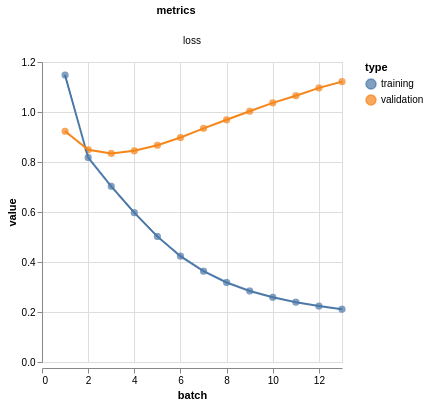

In [17]:
vis.metrics(output.history)

## **Score Of the Model**

In [17]:
score = model.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

313/313 [==============================] - 0s 457us/step - loss: 1.2907


1.2906851768493652

## **Evaluate the Model**

In [18]:
from reco.evaluate import get_embedding, get_predictions, recommend_topk
from reco.evaluate import precision_at_k, recall_at_k, ndcg_at_k

In [19]:
item_embedding = get_embedding(model, "ItemEmbedding")
user_embedding = get_embedding(model, "UserEmbedding")

In [20]:
%%time
predictions = get_predictions(model, DATA)

CPU times: user 22.2 s, sys: 1.73 s, total: 23.9 s
Wall time: 15.5 s


In [21]:
predictions.head()

,USER,ITEM,RATING_PRED
0,195,241,2.932845
1,195,301,3.742528
2,195,376,2.234507
3,195,50,3.797182
4,195,345,3.130107


In [22]:
%%time
# Recommendation for Top10K
ranking_topk = recommend_topk(model, DATA, train, k=5)

CPU times: user 24.5 s, sys: 1.71 s, total: 26.2 s
Wall time: 17.9 s


In [23]:
eval_precision = precision_at_k(test, ranking_topk, k=10)
eval_recall = recall_at_k(test, ranking_topk, k=10)
eval_ndcg = ndcg_at_k(test, ranking_topk, k=10)

print("NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG@K:	0.050328
Precision@K:	0.032238
Recall@K:	0.027983


In [24]:
from reco.recommend import get_similar, show_similar

In [25]:
%%time
item_distances, item_similar_indices = get_similar(item_embedding, 5)

CPU times: user 109 ms, sys: 0 ns, total: 109 ms
Wall time: 109 ms


In [28]:
item_similar_indices

array([[   0, 1108,  809, 1354, 1250],
       [   1, 1188,  972,  393,  559],
       [   2, 1517, 1382,  619, 1283],
       ...,
       [1679, 1672, 1634, 1506, 1644],
       [1680, 1648, 1506, 1618, 1324],
       [1681, 1506, 1340, 1644, 1324]])

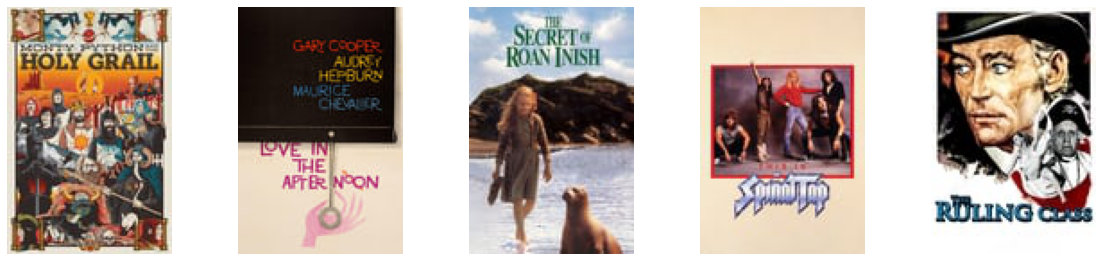

In [29]:
show_similar(167, item_similar_indices, item_encoder)

In [1]:
import tensorflow as tf


In [18]:
tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3,mode="min")